In [1]:

import numpy as np 
import pandas as pd 
import os

from sklearn.model_selection import KFold,StratifiedKFold

import lightgbm as lgbm

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,roc_auc_score,classification_report,auc,precision_score
from sklearn.model_selection import train_test_split



In [61]:
# train = pd.read_csv("train.csv")
# train.drop("ID", axis=1, inplace=True)
# test = pd.read_csv("test.csv")
# train.shape, test.shape

# train['f_2'] = train['f_2'].fillna(1.0)
# train['f_3'] = train['f_3'].fillna(73) # mean
# train['f_5'] = train['f_5'].fillna(3.0)
# train['f_6'] = train['f_6'].fillna(2.0)
# train['f_8'] = train['f_8'].fillna(2.0)
# train['f_9'] = train['f_9'].fillna(3.0)

# quant = 0.99999
# f_1 = train.loc[train['f_1']>train['f_1'].quantile(quant)]
# f_1_index = f_1[f_1['output']==1].index

# f_2 = train.loc[train['f_2']>train['f_2'].quantile(quant)]
# f_2_index = f_2[f_2['output']==1].index

# f_3 = train.loc[train['f_3']>train['f_3'].quantile(quant)]
# f_3_index = f_3[f_3['output']==1].index

# f12 = train.loc[train['f12']>train['f12'].quantile(quant)]
# f12_index = f12[f12['output']==1].index

# temp = []
# for i in [f_1_index , f_2_index,f_3_index,f12_index]:
#     for j in i:
#         temp.append(j)
        
# len(np.unique(temp)), len(f_1_index),len(f_2_index),len(f_3_index),len(f12_index)
# train.drop(f_3.index, axis=0, inplace=True)

No special cases for outliers

In [60]:
# zero_test = train[train['output']==0].sample(1500)
# one_test  = train[train['output']==1].sample(1500)
# full_test = pd.concat([zero_test, one_test], axis=0)

# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import NearMiss

# X = train.drop('output',axis=1)
# y = train['output']

# smk = SMOTETomek(random_state=42)
# X_res,y_res=smk.fit_resample(X,y)

# X_res.drop(full_test.index,axis=0,inplace=True)
# y_res.drop(full_test.index,axis=0,inplace=True)

# X_train, X_val, y_train, y_val = train_test_split(X_res,y_res, test_size=0.9, random_state=0, shuffle=True)

# train = pd.concat([X_train, y_train], axis=1)
# features = [c for c in train.columns if c not in ['output']]
# target = 'output'
# valid =  pd.concat([X_val, y_val], axis=1)

# train.reset_index(drop=True, inplace=True)

In [59]:
# def objective(trial):
    
#     params_optuna = {
        
#         'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 3),
#         #'lambda_l1': trial.suggest_float('lambda_l1', 1e-12, 2, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 5, 25.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 35, 50),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.65, 0.85),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.65),
#         'bagging_freq': trial.suggest_int('bagging_freq', 4, 9),
#          'min_child_samples': trial.suggest_int('min_child_samples', 40, 90),
#          'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 90, 150),
#         "max_depth": trial.suggest_int("max_depth", 6, 12),
        
#         'num_iterations':10000,
#         'learning_rate':0.1
#     }
#     n=3
#     cv = StratifiedKFold(n,shuffle=True, random_state=42)
#     all_scores = []
#     for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
#         X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
#         X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]

#         model = lgbm.LGBMClassifier(**params_optuna)
#         model.fit(X_train,
#                   y_train,
#                   eval_set = [(X_val,y_val)],
#                   early_stopping_rounds=50,
#                   verbose=500)

#         y_pred = model.predict_proba(X_val)[:,1]
#         score = roc_auc_score(y_val,y_pred)
#         all_scores.append(score)
#         print(score)
#     return np.mean(all_scores)

# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(func=objective, n_trials=50)
# study.best_params

In [22]:
best_params={'scale_pos_weight': 1, 'lambda_l2': 5.561283404226013, 'num_leaves': 38, 'feature_fraction': 0.6629453272720298, 'bagging_fraction': 0.6169686657341008, 'bagging_freq': 4, 'min_child_samples': 82, 'min_data_in_leaf': 142, 'max_depth': 6, 'objective': 'binary', 'learning_rate': 0.1}

In [23]:
# best_params = study.best_params
best_params['objective']='binary'
best_params['learning_rate']=0.1

In [58]:
# n=10
# cv = StratifiedKFold(n,shuffle=True, random_state=42)
# test_preds = []

# all_scores = []
# for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
#     X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
#     X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]
    
#     params=best_params
    
#     model = lgbm.LGBMClassifier(**params)
#     model.fit(X_train,
#               y_train,
#               eval_set = [(X_val,y_val)],
#               early_stopping_rounds=50,
#               verbose=500)
    
#     y_pred = model.predict_proba(X_val)[:,1]
#     score = roc_auc_score(y_val,y_pred)
#     all_scores.append(score)
    
#     test_pred = model.predict_proba(full_test[features])[:,1]
#     test_preds.append(test_pred)
#     print(f'=== Fold {i} ROC AUC Score {score} ===')

# print(f'=== Average ROC AUC Score {np.mean(all_scores)} ===')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

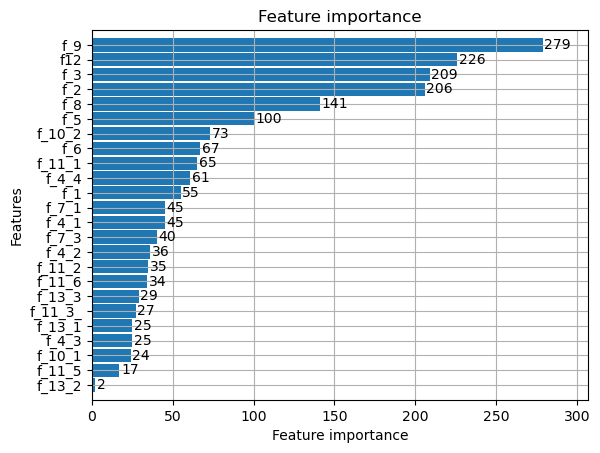

In [28]:
# lgbm.plot_importance(model, max_num_features = 60, height=.9)

f_9, f_12, f_3, f_2, f_8,f_5 are important features

In [46]:
test=pd.read_csv("test.csv")

In [47]:
test['f_2'] = test['f_2'].fillna(1.0)
test['f_3'] = test['f_3'].fillna(73) # mean
test['f_5'] = test['f_5'].fillna(3.0)
test['f_6'] = test['f_6'].fillna(2.0)
test['f_8'] = test['f_8'].fillna(2.0)
test['f_9'] = test['f_9'].fillna(3.0)

In [48]:
prediction = model.predict(test.drop("ID", axis=1))

In [54]:
submission.any= pd.DataFrame()
submission['ID']=test['ID'].values
submission['Prediction']=prediction

In [57]:
submission.to_csv("submission.csv", index=False)

In [ ]:
# for n,ii in enumerate(,rounded_pred):
#     print(ii)